# Reads preprocess
Raw reads from BYO-doped pool k-seq experiments were in `.fastq.gz` format and were preprocessed using `fastq-join` or `pandaSeq` to join pair-end reads, trim primers, and then survey counts for unique reads

In [2]:
from yuning_util.dev_mode import DevMode
dev_mode = DevMode('k-seq')
dev_mode.on()

from importlib import reload
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 240

## Repeat seq_table processing pipeline through pandaSeq joined sequence

In [204]:
# from k_seq.data import seq_table
# reload(seq_table)

# runs = ['allow-mismatch', 'no-mismatch',
#         'allow-mismatch-assembly-first', 'no-mismatch-assembly-first']

# for run in runs:
#     seq_table = seq_table.SeqTable.load_dataset(dataset='byo-doped', from_count_file=True,
#                           count_file_path=f'/mnt/storage/projects/k-seq/working/byo_doped/read_join/{run}/counts/',
#                           pandaseq_joined=True)
#     seq_table.to_pickle(f'/mnt/storage/projects/k-seq/datasets/byo-doped-pandaSeq/{run}.pkl')

Generate SeqTable instance for BYO-doped pool...
Importing from /mnt/storage/projects/k-seq/working/byo_doped/read_join/no-mismatch/counts/...this could take a couple of minutes...
Finished!
Generate SeqTable instance for BYO-doped pool...
Importing from /mnt/storage/projects/k-seq/working/byo_doped/read_join/allow-mismatch-assembly-first/counts/...this could take a couple of minutes...
Finished!
Generate SeqTable instance for BYO-doped pool...
Importing from /mnt/storage/projects/k-seq/working/byo_doped/read_join/no-mismatch-assembly-first/counts/...this could take a couple of minutes...
Finished!


## Sample level analysis

Here we look into sample level analysis on different joining methods, typically what is the passing ratio of total reads and number of uniques sequences, in the process of
- Joining
- Sequence length and spike-in filtering
- Reacted fraction calculation

### Load results
We load in following 

1. raw reads

2. joined reads in various methods (== seq_table.table)

3. seq_table.table_filtered in various methods

4. seq_table.table_filtered_reacted_frac in various methods (recover the counts from index sequences)

In [8]:
from k_seq.utility.func_tools import AttrScope
from k_seq.data.seq_table import SeqTable
reload(seq_table)

reads = AttrScope(raw_reads=None,
                  joined_total=None, joined_unique=None,
                  filtered_total=None, filtered_unique=None,
                  valid_total=None, valid_unique=None)

In [9]:
def get_total_and_unique(table):
    return table.sum(axis=0), (table > 0).sum(axis=0)

def rename_res(name):
    """Rename results loaded from raw reads"""
    return name.split('_')[0].split('-')[-1]

# add raw reads
raw_reads = pd.read_csv('/mnt/storage/projects/k-seq/input/byo_doped/raw_reads/sample_reads.tsv', sep='\t')
sample_reads = raw_reads[raw_reads['R'] == 1].groupby('file').sum()
reads.raw_reads = sample_reads['reads'].rename(rename_res)
reads.raw_reads.index.name = 'sample'
reads.raw_reads.name = 'raw_reads'

methods = ['fastq-join', 'allow-mismatch', 'no-mismatch',
           'allow-mismatch-assembly-first', 'no-mismatch-assembly-first']

# load fastq-joined
seq_table = SeqTable.load_dataset('byo-doped')
total, unique = get_total_and_unique(seq_table.table)
reads.joined_total = pd.DataFrame({'fastq-join': total})
reads.joined_unique = pd.DataFrame({'fastq-join': unique})
total, unique = get_total_and_unique(seq_table.table_filtered)
reads.filtered_total = pd.DataFrame({'fastq-join': total})
reads.filtered_unique = pd.DataFrame({'fastq-join': unique})
total, unique = get_total_and_unique(seq_table.table.loc[seq_table.table_filtered_reacted_frac_spike_in.index])
reads.valid_total = pd.DataFrame({'fastq-join': total})
reads.valid_unique = pd.DataFrame({'fastq-join': unique})

# load pandaSeq results
for run in methods[1:]:
    seq_table = SeqTable.load_dataset(
        'byo-doped',
        pickled_path=f'/mnt/storage/projects/k-seq/datasets/byo-doped-pandaSeq/{run}.pkl'
    )

    reads.joined_total[run], reads.joined_unique[run] = get_total_and_unique(seq_table.table)
    reads.filtered_total[run], reads.filtered_unique[run] = get_total_and_unique(seq_table.table_filtered)
    reads.valid_total[run], reads.valid_unique[run] = get_total_and_unique(seq_table.table.loc[seq_table.table_filtered_reacted_frac_spike_in.index])


Load BYO-doped pool data from pickled record from /mnt/storage/projects/k-seq/datasets/byo-doped.pkl
Imported!
Load BYO-doped pool data from pickled record from /mnt/storage/projects/k-seq/datasets/byo-doped-pandaSeq/allow-mismatch.pkl
Imported!
Load BYO-doped pool data from pickled record from /mnt/storage/projects/k-seq/datasets/byo-doped-pandaSeq/no-mismatch.pkl
Imported!
Load BYO-doped pool data from pickled record from /mnt/storage/projects/k-seq/datasets/byo-doped-pandaSeq/allow-mismatch-assembly-first.pkl
Imported!
Load BYO-doped pool data from pickled record from /mnt/storage/projects/k-seq/datasets/byo-doped-pandaSeq/no-mismatch-assembly-first.pkl
Imported!


### Pair-end reads joining process

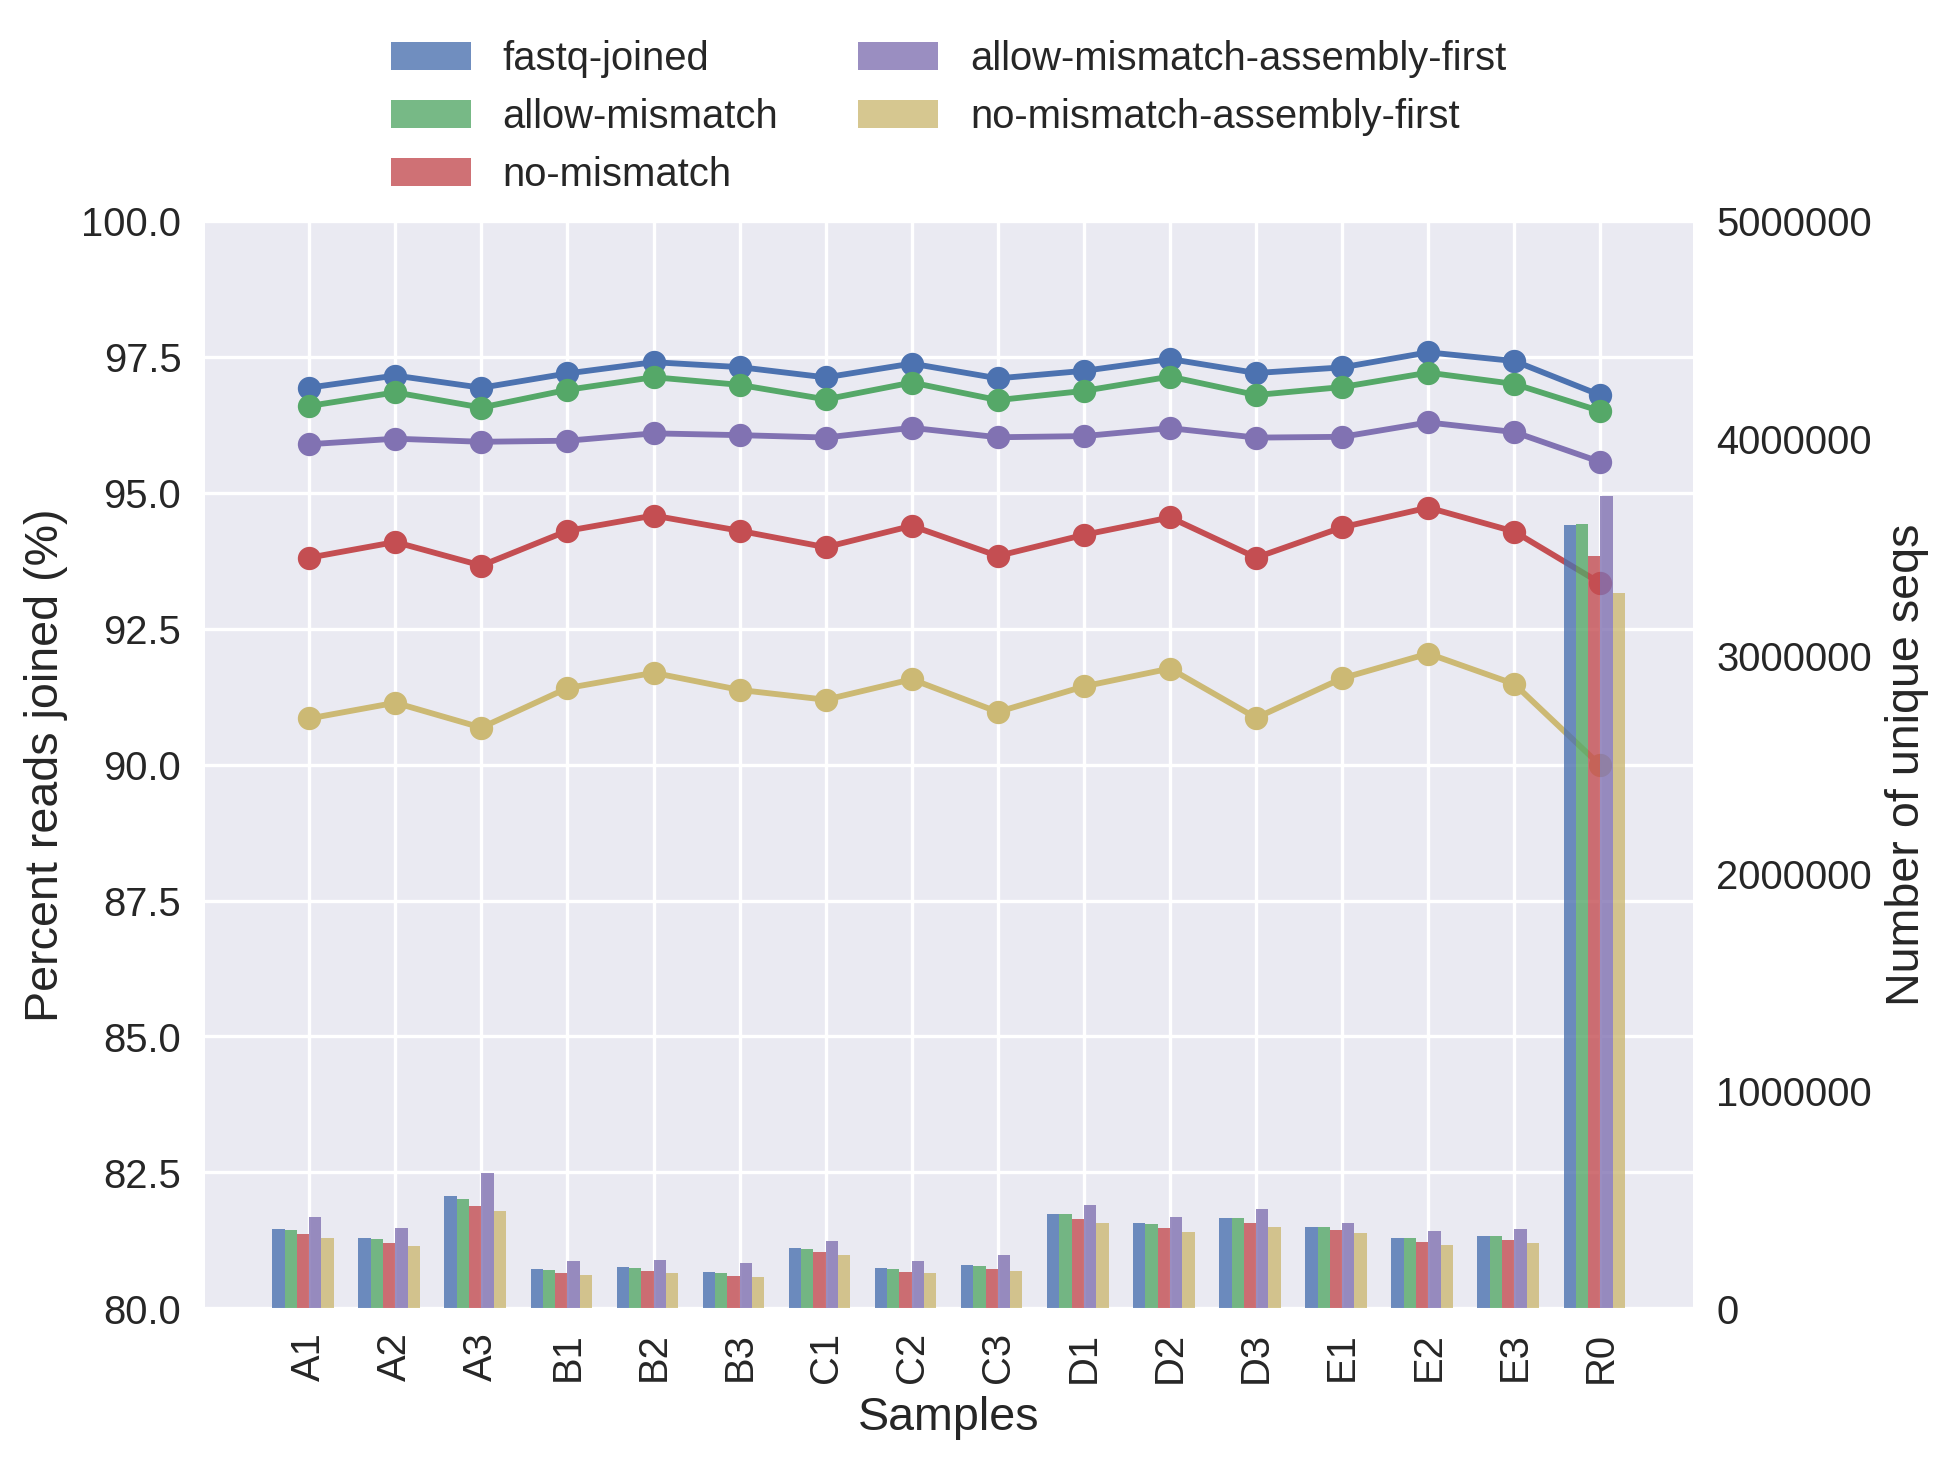

In [277]:
fig, ax = plt.subplots(1, 1, figsize=[8, 6])
pos = np.arange(joined_ratio.shape[0]) * (len(methods) + 2)

ax1 = ax.twinx()

# Barplot for unique sequences
for ix, method in enumerate(methods):
    x = pos + ix + 1
    y = reads.joined_unique[method]
    ax1.bar(x=x, height=y, width=1, align='center', label=method, alpha=0.8, zorder=1)
ax1.set_ylabel('Number of unique seqs', fontsize=14)
ax1.tick_params(labelsize=12)
ax1.set_ylim([0, 5_000_000])
ax1.grid(axis='y', b=None, which='both')

# plot for joined ratio (total reads)
joined_ratio = reads.joined_total.divide(reads.raw_reads, axis=0) * 100

x = pos + 1 + len(methods) / 2
for method in methods:
    ax.plot(x, joined_ratio[method], marker='o', zorder=10)
ax.set_ylabel('Percent reads joined (%)', fontsize=14)
ax.set_ylim([80, 100])
ax.tick_params(labelsize=12)


ax.set_xticks(pos + 1 + len(methods) / 2)
ax.set_xticklabels(joined_ratio.index.values, fontsize=12, rotation=90)
ax.set_xlabel('Samples', fontsize=14)

ax1.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=2, fontsize=12)

plt.show()n

### Filtering: remove spike-in and sequence != 21 nt

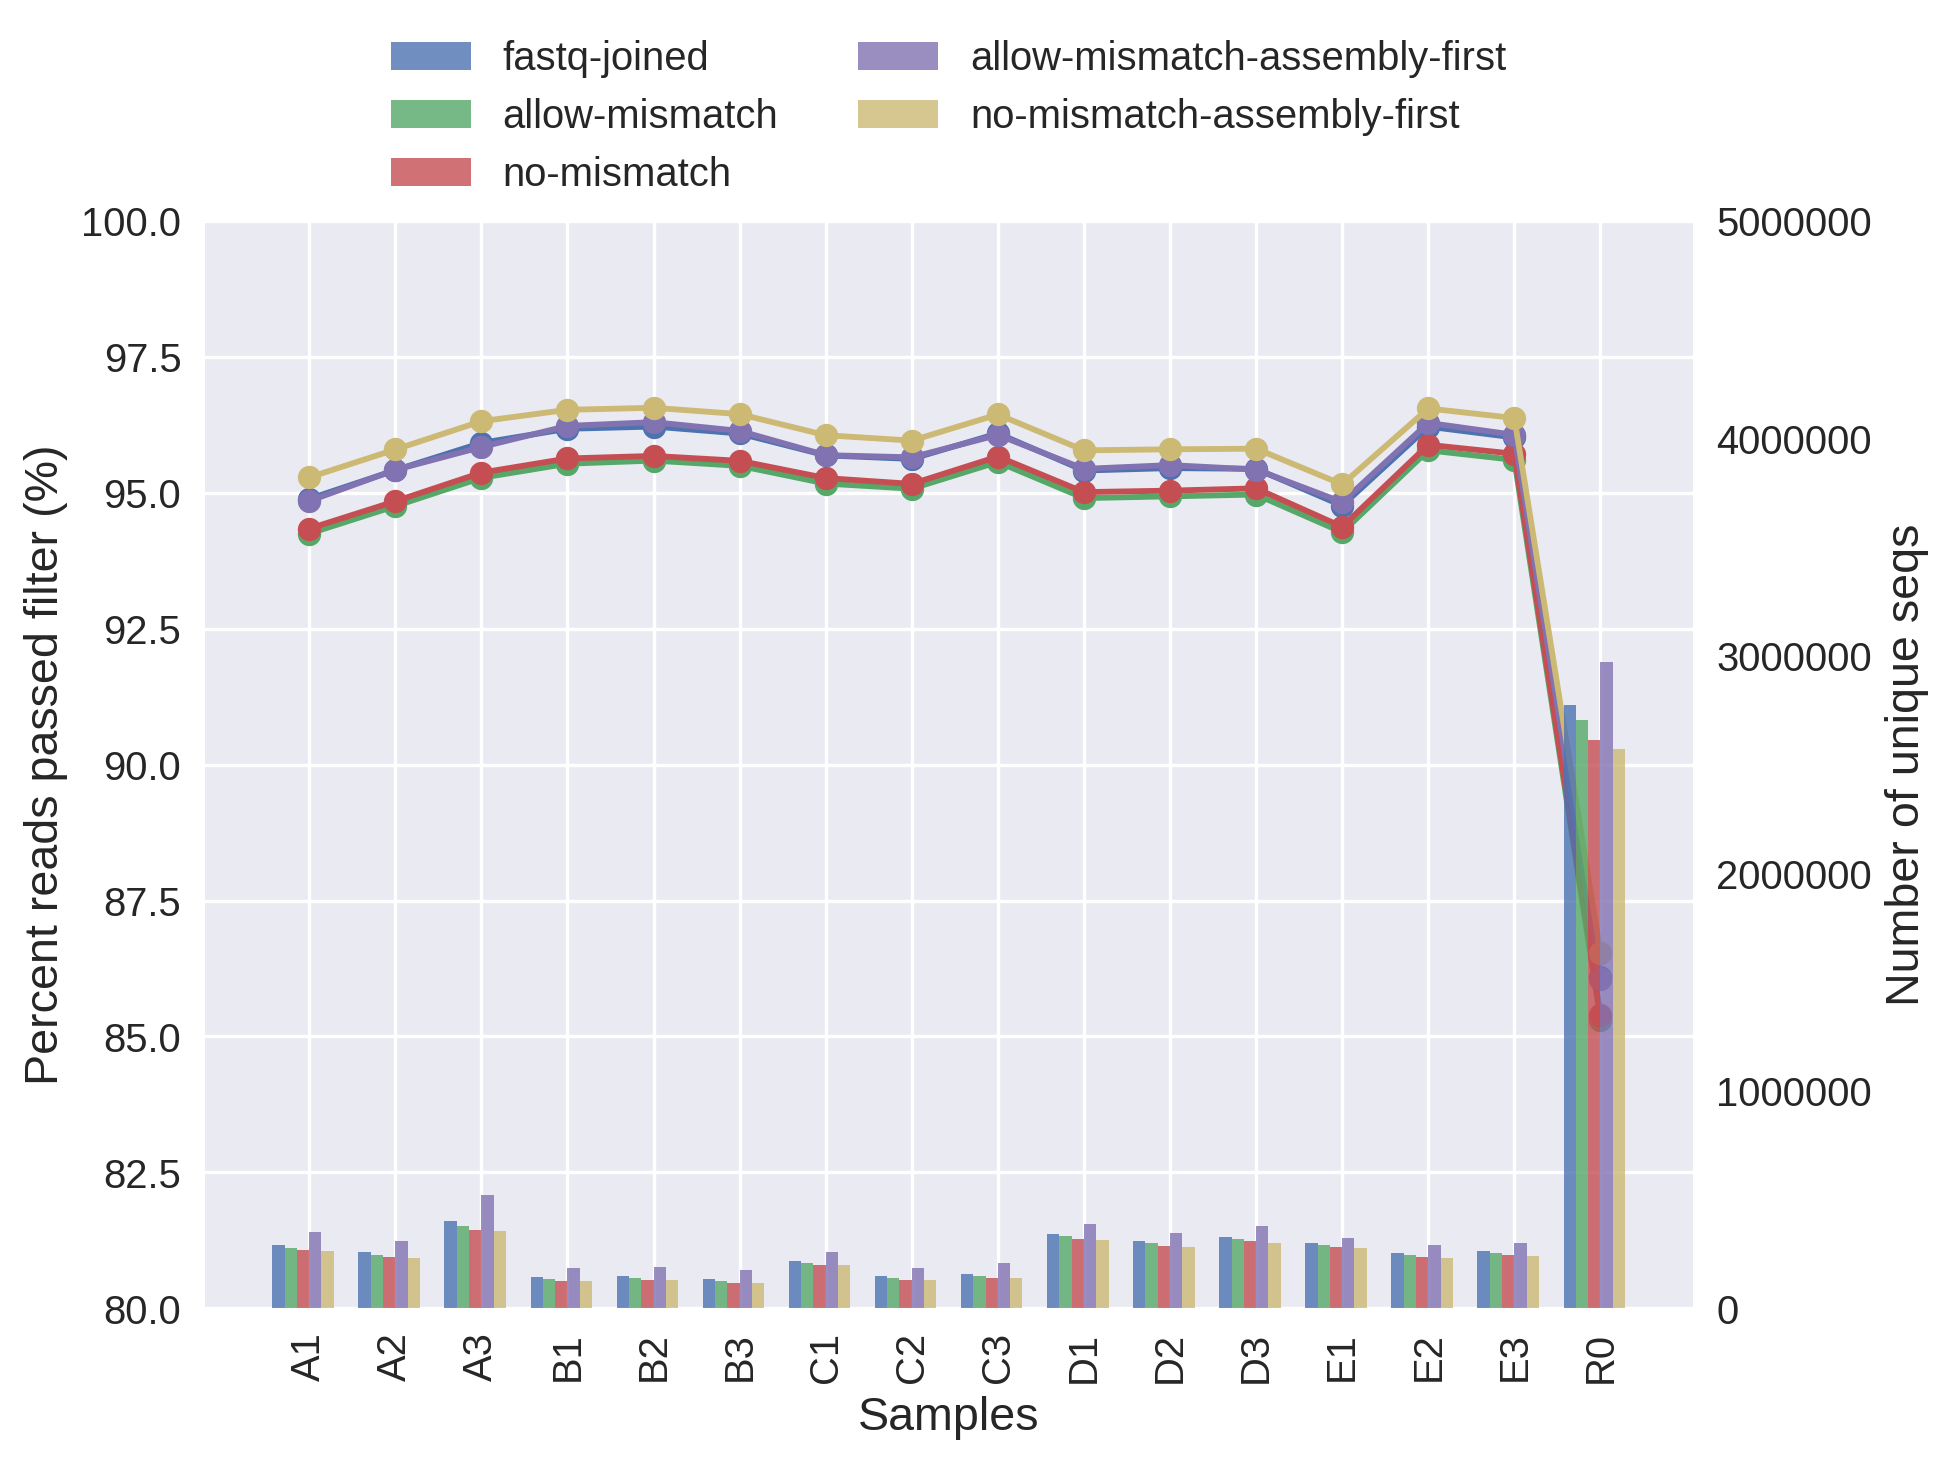

In [278]:
fig, ax = plt.subplots(1, 1, figsize=[8, 6])
pos = np.arange(reads.filtered_total.shape[0]) * (len(methods) + 2)

ax1 = ax.twinx()

# Barplot for unique sequences
for ix, method in enumerate(methods):
    x = pos + ix + 1
    y = reads.filtered_unique[method]
    ax1.bar(x=x, height=y, width=1, align='center', label=method, alpha=0.8, zorder=1)
ax1.set_ylabel('Number of unique seqs', fontsize=14)
ax1.tick_params(labelsize=12)
ax1.set_ylim([0, 5_000_000])
ax1.grid(axis='y', b=None, which='both')

# plot for joined ratio (total reads)
pass_ratio = reads.valid_total.divide(reads.joined_total) * 100

x = pos + 1 + len(methods) / 2
for method in methods:
    ax.plot(x, pass_ratio[method], marker='o', zorder=10)
ax.set_ylabel('Percent reads passed filter (%)', fontsize=14)
ax.set_ylim([80, 100])
ax.tick_params(labelsize=12)

ax.set_xticks(pos + 1 + len(methods) / 2)
ax.set_xticklabels(pass_ratio.index.values, fontsize=12, rotation=90)
ax.set_xlabel('Samples', fontsize=14)

ax1.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=2, fontsize=12)

plt.show()

### Valid sequences

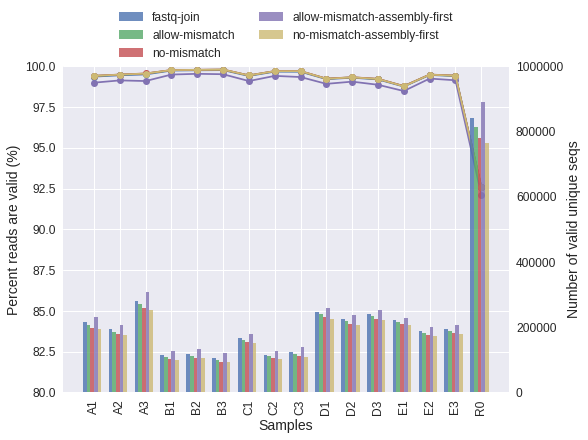

In [12]:
fig, ax = plt.subplots(1, 1, figsize=[8, 6])
pos = np.arange(reads.filtered_total.shape[0]) * (len(methods) + 2)

ax1 = ax.twinx()

# Barplot for unique sequences
for ix, method in enumerate(methods):
    x = pos + ix + 1
    y = reads.valid_unique[method]
    ax1.bar(x=x, height=y, width=1, align='center', label=method, alpha=0.8, zorder=1)
ax1.set_ylabel('Number of valid unique seqs', fontsize=14)
ax1.tick_params(labelsize=12)
ax1.set_ylim([0, 1_000_000])
ax1.grid(axis='y', b=None, which='both')

# plot for joined ratio (total reads)
valid_ratio = reads.valid_total.divide(reads.filtered_total) * 100

x = pos + 1 + len(methods) / 2
for method in methods:
    ax.plot(x, valid_ratio[method], marker='o', zorder=10)
ax.set_ylabel('Percent reads are valid (%)', fontsize=14)
ax.set_ylim([80, 100])
ax.tick_params(labelsize=12)


ax.set_xticks(pos + 1 + len(methods) / 2)
ax.set_xticklabels(valid_ratio.index.values, fontsize=12, rotation=90)
ax.set_xlabel('Samples', fontsize=14)

ax1.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=2, fontsize=12)

plt.show()

### Summarize: from joined sequences to valid sequences

In [24]:
from k_seq.data.seq_table import SeqTable

def get_series(method):
    print(f'Load {method}')
    if method == 'fastq-join':
        seq_table = SeqTable.load_dataset('byo-doped')
    else:
        seq_table = SeqTable.load_dataset(
            'byo-doped',
            pickled_path=f'/mnt/storage/projects/k-seq/datasets/byo-doped-pandaSeq/{method}.pkl'
        )
    valid_table = seq_table.table.loc[seq_table.table_filtered_reacted_frac_spike_in.index.values]
    all_valid_table = seq_table.table.loc[seq_table.table_filtered_seq_in_all_smpl_reacted_frac_spike_in.index.values]
    
    return {
        'Joined': seq_table.table.sum().sum(),
        'Filtered': seq_table.table_filtered.sum().sum(),
        'Valid': valid_table.sum().sum(),
        'In all samples': all_valid_table.sum().sum(),
    }, {
        'Joined': seq_table.table.shape[0],
        'Filtered': seq_table.table_filtered.shape[0],
        'Valid': valid_table.shape[0],
        'In all samples': all_valid_table.shape[0],
    }

In [25]:
total_reads = {}
unique_seqs = {}
for method in methods:
    total_reads[method], unique_seqs[method] = get_series(method)

Load fastq-join
Load BYO-doped pool data from pickled record from /mnt/storage/projects/k-seq/datasets/byo-doped.pkl
Imported!
Load allow-mismatch
Load BYO-doped pool data from pickled record from /mnt/storage/projects/k-seq/datasets/byo-doped-pandaSeq/allow-mismatch.pkl
Imported!


AttributeError: 'SeqTable' object has no attribute 'table_filtered_seq_in_all_smpl_reacted_frac_spike_in'

In [26]:
seq_table = SeqTable.load_dataset(
            'byo-doped',
            pickled_path=f'/mnt/storage/projects/k-seq/datasets/byo-doped-pandaSeq/{method}.pkl'
        )

Load BYO-doped pool data from pickled record from /mnt/storage/projects/k-seq/datasets/byo-doped-pandaSeq/allow-mismatch.pkl
Imported!


In [27]:
seq_table = SeqTable.load_dataset('byo-doped', from_count_file=True)

Generate SeqTable instance for BYO-doped pool...
Importing from /mnt/storage/projects/k-seq/input/byo_doped/counts...this could take a couple of minutes...
Finished!
